# Uczenie maszynowe w Python - Zaliczenie
## E-mail spam classifier

In [47]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import RegexpTokenizer
from textblob import Word
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
import time
from unittest import TestCase
TestCase.maxDiff = None

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tomek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tomek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Analysis of the dataset

In [2]:
class DataPreparator:
    
    def __init__(self, file_name):
        self.df = pd.read_csv(file_name)
        self.email_amount = 0
        self.ham_amount = 0
        self.spam_amount = 0
        self.word_count = 0
        self.avg_words = 0       
        
    # print out the information about the dataset
    def __str__(self):
        mark_line = "-" * 120
        data_info = f'The dataset contains {self.email_amount} emails, {self.ham_amount} ' \
                    f'of which are labeled as non-spam and {self.spam_amount} as spam. Between the emails, ' \
                    f'theres a total of {self.word_count} words,' \
                    f' with an average of ~{self.avg_words} words per email.'
        
        info = "\n".join([mark_line, data_info, mark_line])
        return info
            
    def analize(self):
        
        # label the unnamed column with ids
        self.df.rename(columns={'Unnamed: 0': 'id'}, inplace = True)
        print(80 * "*")
        print("Adding id")
        print(80 * "-")
        print(self.df.head())
        print(80 * "*")

        # amount of emails in the dataset
        self.email_amount = self.df.shape[0]
        
        
        # Series with the amount of words in each email and their total count
        words_in_emails = (self.df['text'].apply(lambda x: len(str(x).split(" "))))
        self.word_count = np.sum(words_in_emails)
        
        # average amount of words in each email
        self.avg_words = round(np.divide(self.word_count, self.email_amount), 2)
        
        # amount of spam and ham emails 
        ham_and_spam_amount= self.df.groupby(['label']).count()
        self.ham_amount = ham_and_spam_amount.iloc[0, 0]
        self.spam_amount = ham_and_spam_amount.iloc[1, 0]



# 2. Normalizing the e-mail contents

In [3]:
class DataCleaner:
    
    def __init__(self, df):
        self.df = df
        
    
    def applying_clean_contents(self):
        
        # apply the function to each row of the dataframe
        self.df['text_clean'] = self.df['text'].apply(lambda string: clean_contents(string))
        print(80 * "*")
        print("Cleaned contents")
        print(80 * "-")
        print(self.df.head())  # printing 5 rows after
        
   
    def cleaning_stopwords(self):
        stop = stopwords.words('english')
        self.df['text_clean'] = self.df['text_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
        print(80 * "*")
        print("Without stopwords")
        print(80 * "-")
        print(self.df.head())
    
    # lemmatize the cleaned email contents
    def lemmatization(self):
        self.df['text_clean'] = self.df['text_clean'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

        # show the first 10 rows after lemmatizing
        print(80 * "*")
        print("After lemmatization")
        print(80 * "-")
        print(self.df['text_clean'].head(10))
        
    def clean_most_frequent_words(self):
        
        # define the most frequent words in the emails
        frequent_words = pd.Series(' '.join(self.df['text_clean']).split()).value_counts()
        frequent_words = frequent_words[frequent_words > 1000]
        
        # remove them from the email contents
        frequent_words = list(frequent_words.index)
        self.df['text_clean'] = self.df['text_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in frequent_words))
        #print(80 * "*")
        #print("After deleting the most frequent words")
        #print(80 * "-")
        #print(self.df['text_clean'].head(10))
        
# clean the contents of each email
def clean_contents(string, reg = RegexpTokenizer(r'[a-z]+')):
    string = string.lower()
    tokens = reg.tokenize(string)
    return " ".join(tokens)



# 3. Visualisation

In [4]:
class Plots:
    
    def __init__(self, cleaned_data):
        self.df = cleaned_data.df
        
    def show_plot_second_step(self):
        self.df['label'].value_counts().plot.bar(color = ["g","r"])
        plt.title('Total number of ham and spam in the dataset')
        plt.show()
       

# 4. Vectorization

In [5]:
class VectorAndTrain:
    
    def __init__(self, cleaned_data):
        self.df = cleaned_data.df
        
    def vectorization(self):
        
        # Convert a collection of text documents to a matrix of token counts
        cv = CountVectorizer()
        X = cv.fit_transform(self.df.text_clean)
        # Get the categories
        y = self.df.label
        # Words exctracted from text_clean
        print(cv.get_feature_names()[10:50:2])
        
        return X, y
    
    def train(self, X ,y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        return X_train, X_test, y_train, y_test        

# 5. Defining and training the model

In [6]:
class ModelEvaluator():
    #constructor
    def __init__(self, models):
        self.models = models
    
    # handles traing given models
    def train(self, X_train, y_train):
        for name, model in self.models.items():
            start = time.time()
            model['modelObj'].fit(X_train, y_train)
            end = time.time()
            print(f'model {name} trained succesfully in time: {round(end - start,2)} seconds!')
    
    # handles scoring given models
    def score(self, X_test, y_test):
        for name, model in self.models.items():
            print(f"{name}\tscore:\t{model['modelObj'].score(X_test, y_test)}")
    
    # creates dataframe with model name and model accuracy
    def get_dataframe(self, X_test, y_test):
        models_arr=[]
        for name, model in self.models.items(): # add to array name and score of the model
            models_arr.append([name, model['modelObj'].score(X_test, y_test)])
            
        models_df = pd.DataFrame(models_arr) # create dataframe out of the models array
        models_df.columns = ['Model', 'Accuracy'] # add columns 
        
        # sort values by model's accuracy
        models_df.sort_values(by='Accuracy', ascending = False, inplace=True) 
        
        #reset index
        models_df.reset_index(drop = True, inplace = True)
        
        return models_df
    
    # checks which model did best and returs it
    def get_most_accurate_model(self, X_test, y_test):
        best_model = None
        max_score = 0
        for name, model in self.models.items():
            model_score = model['modelObj'].score(X_test, y_test)
            if(model_score > max_score):
                max_score = model_score
                best_model = model['modelObj']
        
        return best_model
    
    # handles testing model
    def test(self, model, text_message, label):
        print(f"MODEL USED: {model}")
        message_vec = cv.transform([text_message])
        prediction = model.predict(message_vec)
        
        print(f"Given Label: {label}\tPredicted label: {prediction[0]}" )
        print(f"""Email message
            {text_message}
        """)

# 6. Unit tests

In [60]:
class TestSuite(unittest.TestCase):
    
    # testing the methods that normalize the text before its analysis
    def test_lemmatization(self):   
        
        lem_test_data = {'text_clean':['multiple scenarios', 'advanced technologies']}
        df_lem_test = pd.DataFrame(lem_test_data)
        
        DataCleaner(df_lem_test).lemmatization()
        self.assertEqual('multiple scenario', df_lem_test.iloc[0,0])
        self.assertEqual('advanced technology', df_lem_test.iloc[1,0])
        
    def test_stopwords(self):
        
        stopwords_test_data = {'text_clean': ['me myself and i', 'it is all the two of us have']}
        df_stopwords_test = pd.DataFrame(stopwords_test_data)
        
        DataCleaner(df_stopwords_test).cleaning_stopwords()
        self.assertEqual('', df_stopwords_test.iloc[0,0])
        self.assertEqual('two us', df_stopwords_test.iloc[1,0])
        
    def test_frequent_words(self):
        
        frequentwords_test_data = {'text_clean': ['test ' * 1001, 'test1 test1']}
        df_frequentwords_test = pd.DataFrame(frequentwords_test_data)
        
        DataCleaner(df_frequentwords_test).clean_most_frequent_words()
        self.assertEqual('', df_frequentwords_test.iloc[0,0])
        self.assertEqual('test1 test1', df_frequentwords_test.iloc[1,0])

# running all the defined tests
unittest.main(argv=[''], verbosity=2, exit=False)

test_frequent_words (__main__.TestSuite) ... ok
test_lemmatization (__main__.TestSuite) ... ok
test_stopwords (__main__.TestSuite) ... 

********************************************************************************
After lemmatization
--------------------------------------------------------------------------------
0      multiple scenario
1    advanced technology
Name: text_clean, dtype: object
********************************************************************************
Without stopwords
--------------------------------------------------------------------------------
  text_clean
0           
1     two us


ok

----------------------------------------------------------------------
Ran 3 tests in 0.007s

OK


# 7. Execution of the previously defined methods

********************************************************************************
Adding id
--------------------------------------------------------------------------------
     id label                                               text  label_num
0   605   ham  Subject: enron methanol ; meter # : 988291\r\n...          0
1  2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...          0
2  3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...          0
3  4685  spam  Subject: photoshop , windows , office . cheap ...          1
4  2030   ham  Subject: re : indian springs\r\nthis deal is t...          0
********************************************************************************
------------------------------------------------------------------------------------------------------------------------
The dataset contains 5171 emails, 3672 of which are labeled as non-spam and 1499 as spam. Between the emails, theres a total of 1083244 words, with an average of ~209.48 

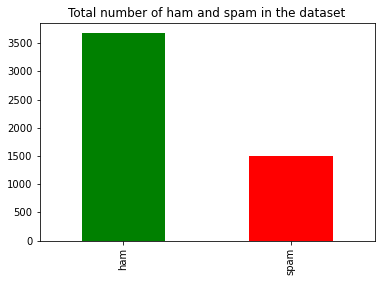

['aaihmqv', 'aalland', 'aamlrg', 'aare', 'aaron', 'aavilable', 'ab', 'ababa', 'aback', 'abacus', 'abandon', 'abandoned', 'abasement', 'abashed', 'abater', 'abb', 'abbasi', 'abbey', 'abbott', 'abbreviation']


In [9]:
# first step
first_step = DataPreparator("spam_ham_dataset.csv")
first_step.analize()
print(first_step)

# second step
second_step = DataCleaner(first_step.df)

second_step.applying_clean_contents()
second_step.cleaning_stopwords()
second_step.lemmatization()
second_step.clean_most_frequent_words()

# second step - plot
plot = Plots(second_step)
plot.show_plot_second_step()

# third_step 
third_step = VectorAndTrain(second_step)  

X, y = third_step.vectorization()
X_train, X_test, y_train, y_test = third_step.train(X,y)


# 8. Evaluation using different models

In [10]:
# Create model dict
models = {
    "RandomForest": {"modelObj": RandomForestClassifier()},
    "KNeighbors": {"modelObj": KNeighborsClassifier()},
    "LogisticRegress": {"modelObj": LogisticRegression()},
    "DecisionTree": {"modelObj": DecisionTreeClassifier()}
}


modelEval = ModelEvaluator(models)

# run traning and scoring:
modelEval.train(X_train, y_train)
print("-" * 50) 
modelEval.score(X_test, y_test)
print("-" * 50)

model RandomForest trained succesfully in time: 5.88 seconds!
model KNeighbors trained succesfully in time: 0.0 seconds!
model LogisticRegress trained succesfully in time: 0.22 seconds!
model DecisionTree trained succesfully in time: 1.02 seconds!
--------------------------------------------------
RandomForest	score:	0.970048309178744
KNeighbors	score:	0.7845410628019324
LogisticRegress	score:	0.9739130434782609
DecisionTree	score:	0.9217391304347826
--------------------------------------------------


<BarContainer object of 4 artists>

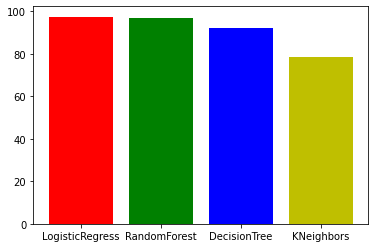

In [11]:
# Display accuracy as bar chart
models_df = modelEval.get_dataframe(X_test, y_test)
model_names = models_df['Model']
model_acc = models_df['Accuracy']

plt.xticks(np.arange(len(model_names)), model_names)
plt.bar(np.arange(len(model_names)), model_acc*100, color=['r', 'g', 'b', 'y'])

# 9. Choose and check the best model's work

In [62]:
# get the most accurate model:
best_model = modelEval.get_most_accurate_model(X_test, y_test)

# test the model
df_spam = third_step.df[third_step.df['label'] == 'spam']
df_ham = third_step.df[third_step.df['label'] == 'ham']

for i in range(0, 5):
    modelEval.test(best_model, df_spam['text_clean'].iloc[i], df_spam['label'].iloc[i])
    print("="*100)
    
for i in range(0, 5):
    modelEval.test(best_model, df_ham['text_clean'].iloc[i], df_ham['label'].iloc[i])
    print("="*100)

MODEL USED: LogisticRegression()


NameError: name 'cv' is not defined